In [1]:
import pandas as pd
import numpy as np
# from relative_fitness_mechanisms.selective_pressure_prediction import (create_lagged_features, 
#                                                                        process_inputs_all, 
#                                                                        withhold_test_locations_and_split)


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import string

In [2]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils
from selective_pressure_prediction import (create_lagged_features, 
                                           process_inputs_all, 
                                            withhold_test_locations_and_split)

In [3]:
selective_pressure_df = pd.read_csv("../data/selective_pressure_growth_cases_full.tsv", sep="\t")
#selective_pressure_df = pd.read_csv("../data/selective_pressure_growth_cases.tsv", sep="\t")

selective_pressure_df["date"] = pd.to_datetime(selective_pressure_df["date"])
selective_pressure_df = selective_pressure_df.dropna()

In [4]:
selective_pressure_df["log_smooth_cases"] = np.log(selective_pressure_df["smooth_cases"])

In [5]:
input_dfs = {}
TARGET = "empirical_growth_rate"
TARGET = "log_smooth_cases"
keep_features = ["date", "location", "selective_pressure"]
keep_targets = [TARGET]

add_location_intercept = True
# Create lagged features by group
for loc, group in selective_pressure_df.groupby("location"):
    input_dfs[loc] = create_lagged_features(
        group[keep_features + keep_targets], 
        ["selective_pressure"], 
        28)

In [6]:
WITHHELD_LOCATIONS = ["England"]
dates_vec, locations_vec, X, y = process_inputs_all(input_dfs, target=TARGET, add_location_intercept=True)
X_train, y_train, X_test, y_test = withhold_test_locations_and_split(X, y, locations_vec, WITHHELD_LOCATIONS)

In [7]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [8]:
# Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1e-2),
    'Lasso': Lasso(alpha=1e-6),
    'RandomForest': RandomForestRegressor(n_estimators=100),
    'GradientBoostingA': GradientBoostingRegressor(loss="absolute_error", n_estimators=100, max_depth=3),
    'GradientBoostingB': GradientBoostingRegressor(loss="absolute_error", n_estimators=100, max_depth=5),
    'GradientBoostingC': GradientBoostingRegressor(loss="absolute_error", n_estimators=200, max_depth=3),
    'GradientBoostingD': GradientBoostingRegressor(loss="absolute_error", n_estimators=200, max_depth=5),
    'GradientBoostingE': GradientBoostingRegressor(loss="absolute_error", n_estimators=200, max_depth=7),

}
model_scores = {model: [] for model in models}

# Define the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Perform time series cross-validation for model selection
for i, (train_index, val_index) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index].values[:,0], y.iloc[val_index].values[:, 0]

    # Initialize and train your linear model within each split
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        mse = mean_squared_error(y_val, predictions)
        
        # Append the MSE to the model's list of scores
        model_scores[model_name].append(mse)
    print(f"Split {i+1} completed.")

for model_name, scores in model_scores.items():
    print(f"{model_name}: Mean MSE = {np.mean(scores):.4f}, Std MSE = {np.std(scores):.4f}")
    
best_model_name = min(model_scores, key=lambda k: np.mean(model_scores[k]))

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.496e+00, tolerance: 7.475e-01
  model = cd_fast.enet_coordinate_descent(


Split 1 completed.


/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.094e+00, tolerance: 1.211e+00
  model = cd_fast.enet_coordinate_descent(


Split 2 completed.


/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.924e+01, tolerance: 1.800e+00
  model = cd_fast.enet_coordinate_descent(


Split 3 completed.


/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.763e+02, tolerance: 2.607e+00
  model = cd_fast.enet_coordinate_descent(


Split 4 completed.


/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.417e+02, tolerance: 3.125e+00
  model = cd_fast.enet_coordinate_descent(


Split 5 completed.
LinearRegression: Mean MSE = 63340155241876856766464.0000, Std MSE = 126680310483753713532928.0000
Ridge: Mean MSE = 2.4759, Std MSE = 2.2567
Lasso: Mean MSE = 3.1662, Std MSE = 3.2408
RandomForest: Mean MSE = 2.6086, Std MSE = 1.6295
GradientBoostingA: Mean MSE = 1.9292, Std MSE = 1.3745
GradientBoostingB: Mean MSE = 1.9457, Std MSE = 1.4673
GradientBoostingC: Mean MSE = 2.1076, Std MSE = 1.5732
GradientBoostingD: Mean MSE = 2.0284, Std MSE = 1.4992
GradientBoostingE: Mean MSE = 2.0627, Std MSE = 1.5870


In [9]:
# Retrain best model
best_model = models[best_model_name]
best_model.fit(X, y)
predictions = best_model.predict(X_test)

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


In [10]:
import pickle 

with open('relative_incidence_model.pkl','wb') as f:
    pickle.dump(best_model,f)

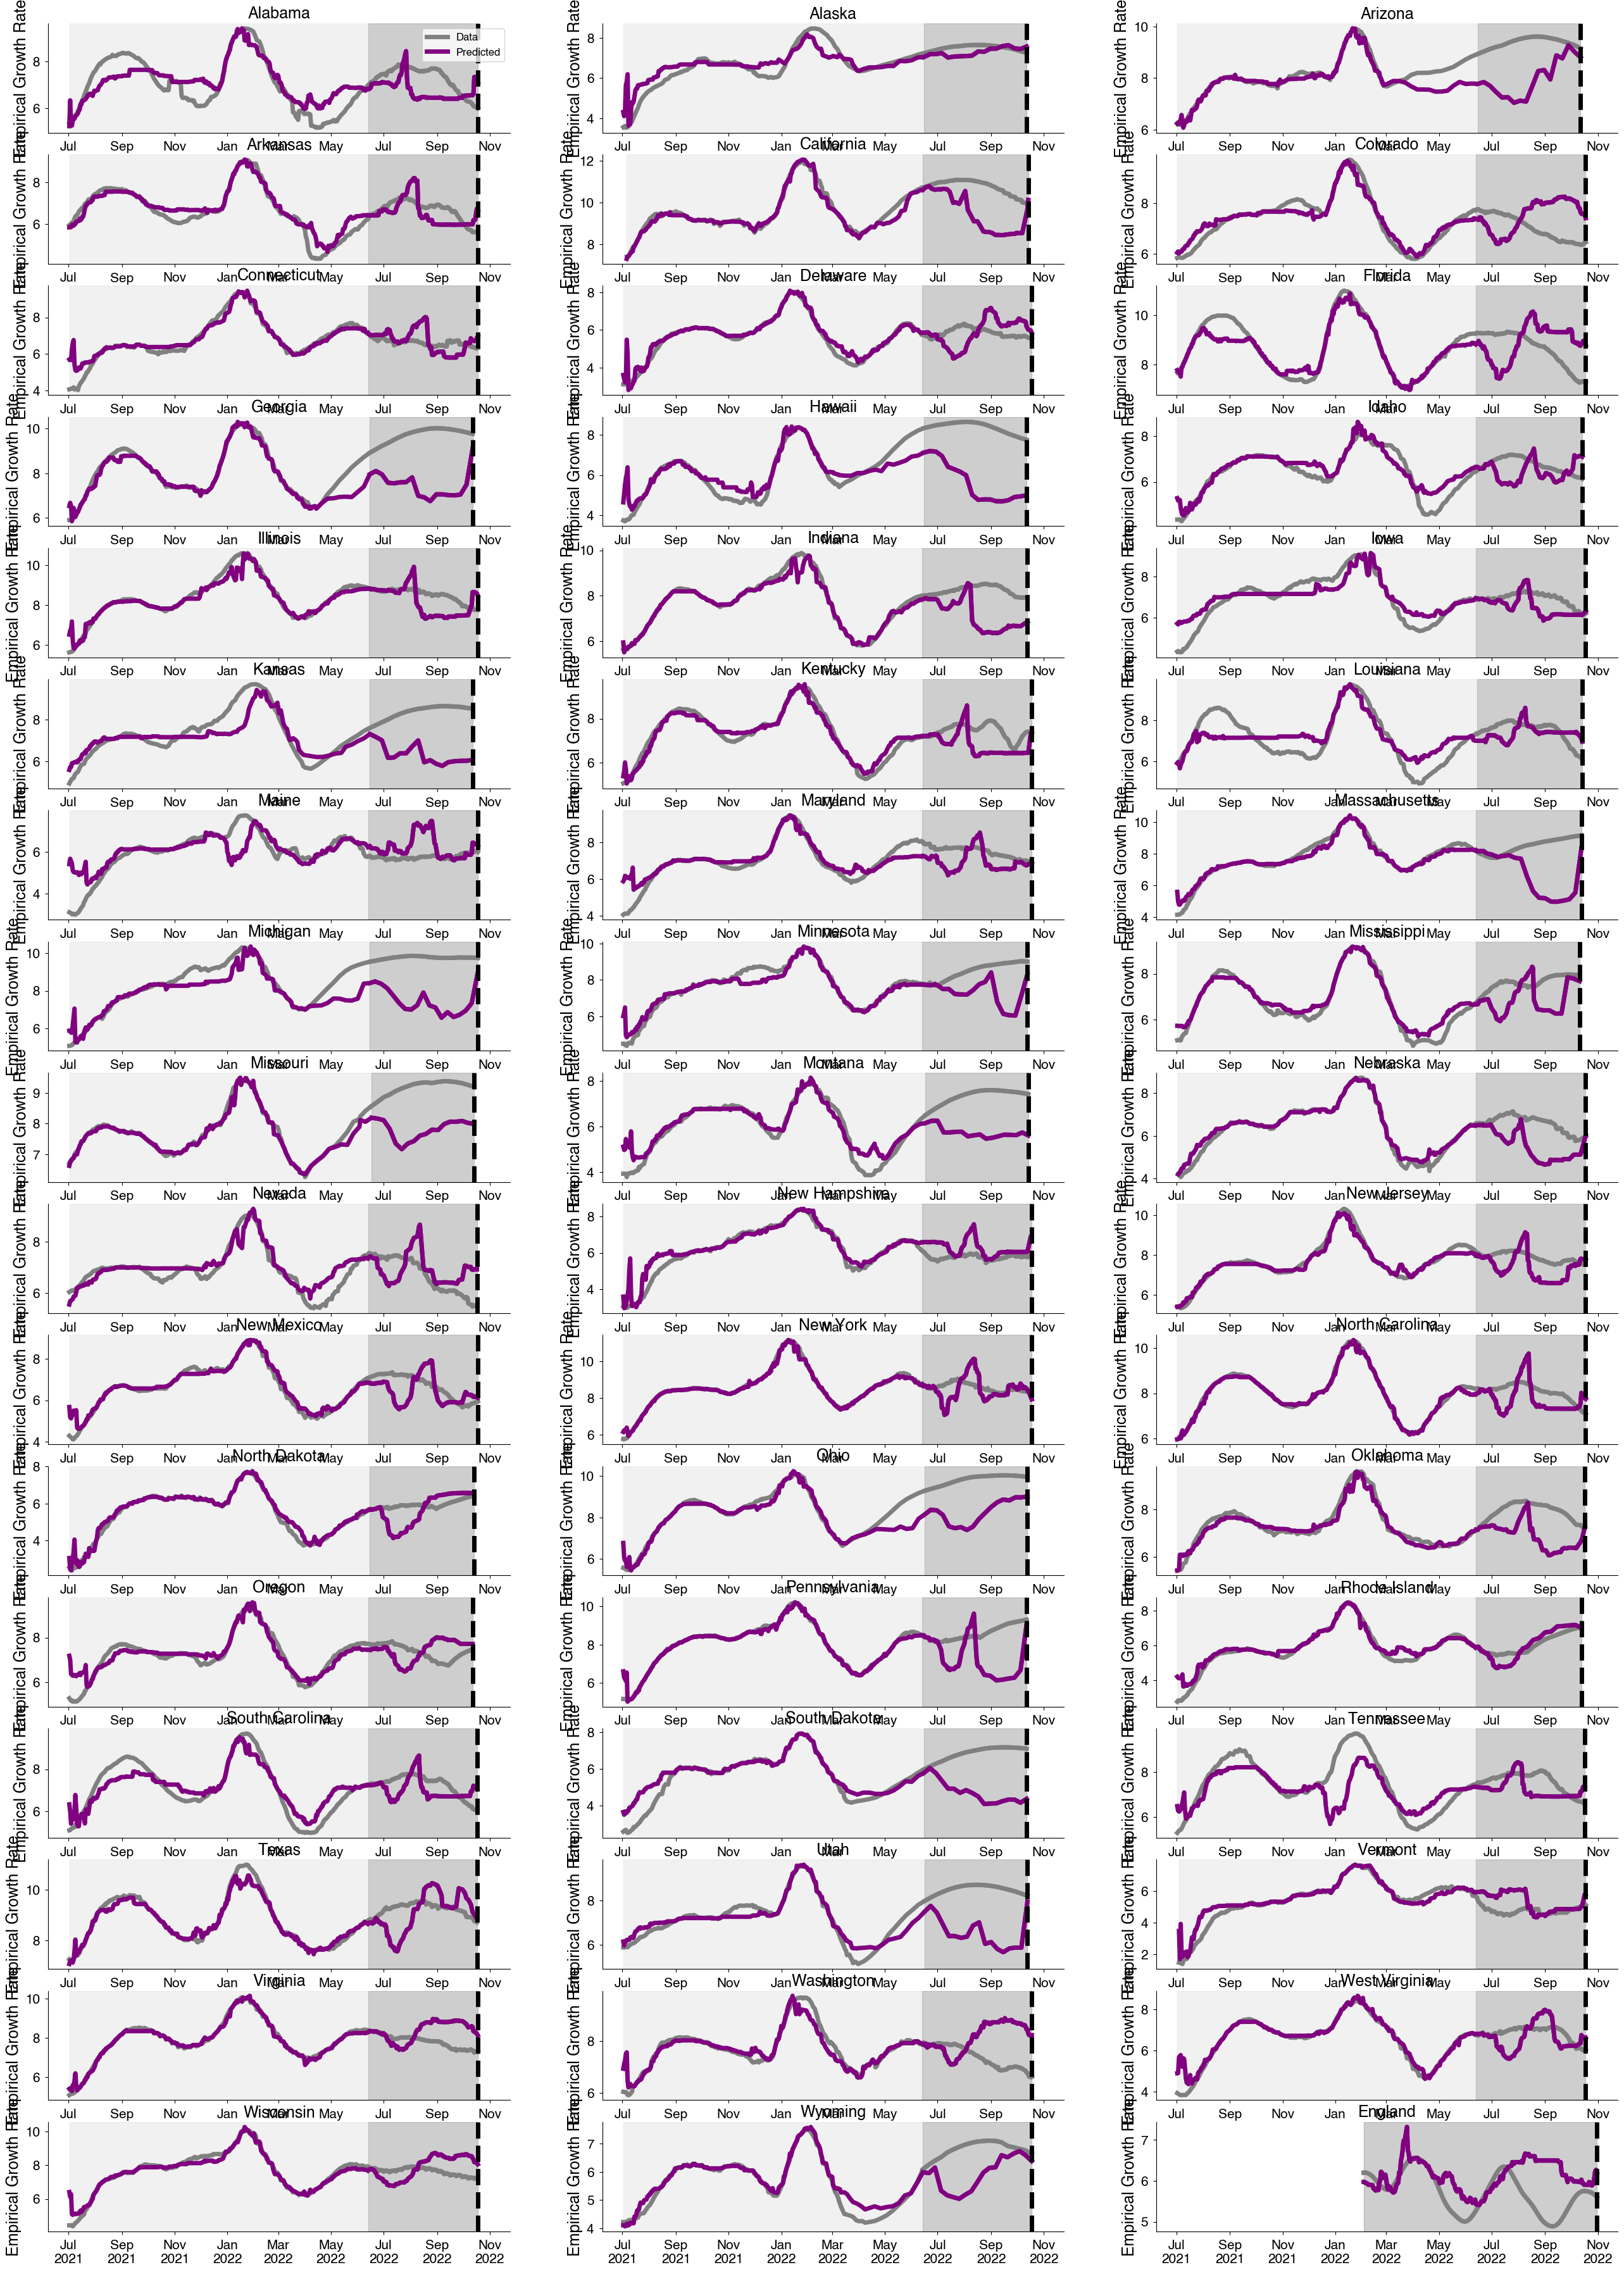

In [11]:
def plot_yeqx(ax):
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
        ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
        return None
    
locations = selective_pressure_df["location"].unique()
fig = plt.figure(figsize=(32, 48))
spec = fig.add_gridspec(ncols=3, nrows=len(locations) // 3 + 1)

for l, loc in enumerate(locations):
    ax = fig.add_subplot(spec[l], sharex=None if l==0 else ax)
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X.index]
    loc_idx_test = loc_idx[X_test.index]

    # Plot data points
    ax.plot(dates_vec[X.index][loc_idx_train], y[loc_idx_train], color="grey", label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color="grey")
    
    # Make predictions
    predictions = model.predict(X)
    predictions_test = model.predict(X_test)

    ax.plot(dates_vec[X.index][loc_idx_train], predictions[loc_idx_train], color="purple", label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], predictions_test[loc_idx_test], color="purple")
    
    # Highlight test and training sets
    min_train_time, max_train_time = dates_vec[X.index][loc_idx_train].min(), dates_vec[X.index][loc_idx_train].max()
    if not pd.isnull(max_train_time):
        ax.axvline(max_train_time, color="k", linestyle="--")
        ax.axvspan(min_train_time, max_train_time, color="lightgrey", alpha=0.3)
    
    min_test_time, max_test_time = dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max()
    if not pd.isnull(max_test_time):
        ax.axvspan(min_test_time, max_test_time, color="grey", alpha=0.3)

    ax.set_ylabel("Empirical Growth Rate")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    if l == 0:
        ax.legend()

#fig.savefig("figures/empirical-growth-rate-predictions.png")

In [12]:
# Subset locations
locations_subset = ["California",   "Michigan", "Nevada", "New York", "Texas", "Washington"]
target_locations = ["England"]

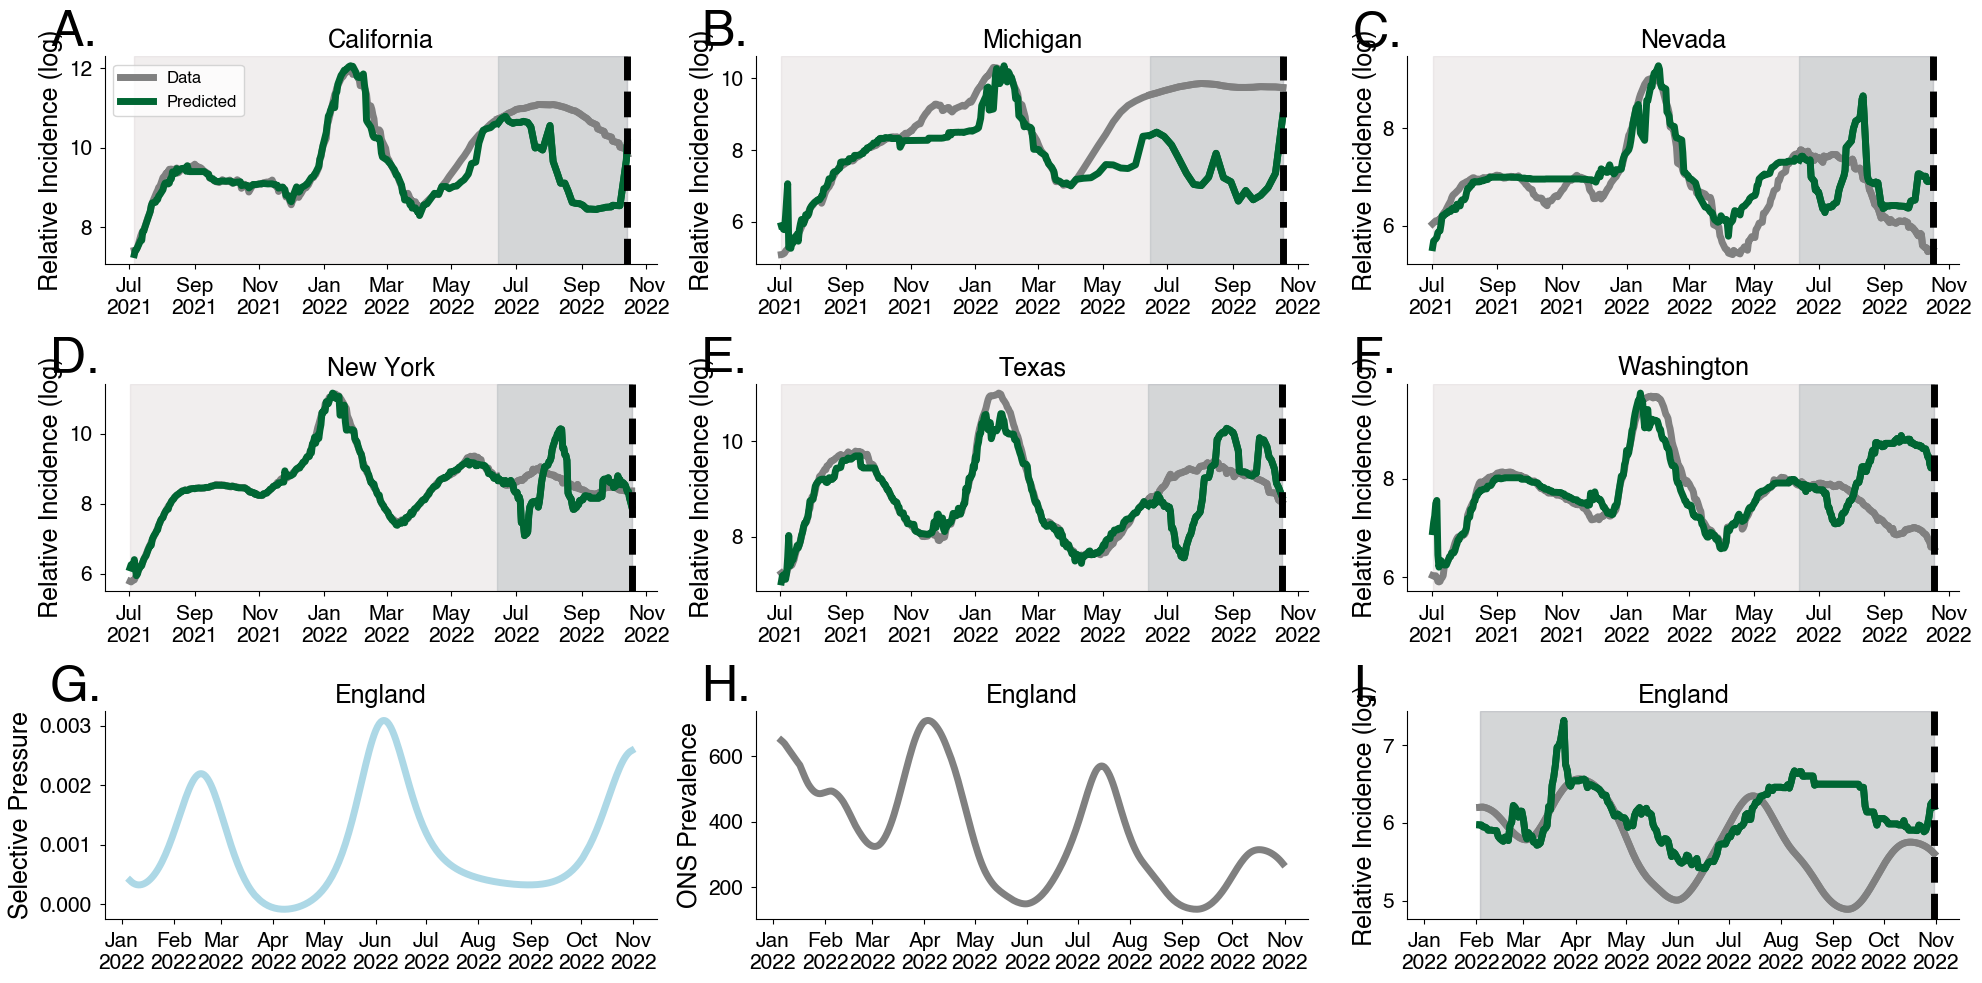

In [13]:
fig = plt.figure(figsize=(20, 10))
spec = fig.add_gridspec(ncols=3, nrows=len(locations_subset) // 3 + 1)

TRAIN_PERIOD_COLOR, TEST_PERIOD_COLOR = "#d1c7c9", "#949fa5"
PREDICTION_COLOR = "#006633"
DATA_COLOR = "grey"

data = {loc: df for loc, df in selective_pressure_df.groupby("location")}
axes = []

for l, loc in enumerate(locations_subset):
    ax = fig.add_subplot(spec[l], sharex=None if l==0 else ax)
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X.index]
    loc_idx_test = loc_idx[X_test.index]

    # Plot data points
    ax.plot(dates_vec[X.index][loc_idx_train], y[loc_idx_train], color=DATA_COLOR, label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color=DATA_COLOR)
    
    # Make predictions
    predictions = model.predict(X)
    predictions_test = model.predict(X_test)

    ax.plot(dates_vec[X.index][loc_idx_train], predictions[loc_idx_train], color=PREDICTION_COLOR, label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], predictions_test[loc_idx_test], color=PREDICTION_COLOR)
    
    # Highlight test and training sets
    min_train_time, max_train_time = dates_vec[X.index][loc_idx_train].min(), dates_vec[X.index][loc_idx_train].max()
    if not pd.isnull(max_train_time):
        ax.axvline(max_train_time, color="k", linestyle="--")
        ax.axvspan(min_train_time, max_train_time, color=TRAIN_PERIOD_COLOR, alpha=0.3)
    
    min_test_time, max_test_time = dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max()
    if not pd.isnull(max_test_time):
        ax.axvspan(min_test_time, max_test_time, color=TEST_PERIOD_COLOR, alpha=0.3)
    
    ax.set_ylabel("Relative Incidence (log)")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    if l == 0:
        ax.legend()
    axes.append(ax)
    
# Add in target_locations
last_l = l
for l, loc in enumerate(target_locations):
    
    # Add selective pressure
    _l = 0
    ax = fig.add_subplot(spec[-1, 0], sharex=None if _l==0 else ax)
    ax.plot(data[loc]["date"], data[loc]["selective_pressure"], color="lightblue")
    ax.set_ylabel("Selective Pressure")
    ax.set_title(loc)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axes.append(ax)
    
    # Add prevalence
    ax = fig.add_subplot(spec[-1, 1], sharex = ax)    
    ax.plot(data[loc]["date"], data[loc]["smooth_cases"], color="grey")
    ax.set_title(loc)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    ax.set_ylabel("ONS Prevalence")
    axes.append(ax)
   
    # Add predictions
    ax = fig.add_subplot(spec[-1, -1], sharex=ax)
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X.index]
    loc_idx_test = loc_idx[X_test.index]
    
    # Plot data points
    ax.plot(dates_vec[X.index][loc_idx_train], y[loc_idx_train], color=DATA_COLOR, label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color=DATA_COLOR)
    
    # Make predictions
    predictions = model.predict(X)
    predictions_test = model.predict(X_test)

    ax.plot(dates_vec[X.index][loc_idx_train], predictions[loc_idx_train], color=PREDICTION_COLOR, label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], predictions_test[loc_idx_test], color=PREDICTION_COLOR)
    
    # Highlight test and training sets
    min_train_time, max_train_time = dates_vec[X.index][loc_idx_train].min(), dates_vec[X.index][loc_idx_train].max()
    if not pd.isnull(max_train_time):
        ax.axvline(max_train_time, color="k", linestyle="--")
        ax.axvspan(min_train_time, max_train_time, color=TRAIN_PERIOD_COLOR, alpha=0.3)
    
    min_test_time, max_test_time = dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max()
    if not pd.isnull(max_test_time):
        ax.axvspan(min_test_time, max_test_time, color=TEST_PERIOD_COLOR, alpha=0.3)
    
    ax.set_ylabel("Relative Incidence (log)")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axes.append(ax)

ax_labels = string.ascii_uppercase 
for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.1, 1.05, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')
fig.tight_layout()


# TODO: Could add part that has variant frequencies
#fig.savefig("../manuscript/figures/selective_pressure_prediction_relative_incidence.png")

In [14]:
## LET'S LOOK AT RESIDUALS

In [15]:
def fit_linear_regression(x, y):
    # Fit linear regression using scipy's linregress
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Calculate R-squared value
    r_squared = r_value**2
    
    # Correlation coefficient is the r_value from linregress
    corr_coeff = r_value
    
    # Line of best fit
    line_of_best_fit = slope * x + intercept
    
    return line_of_best_fit, r_squared, corr_coeff

In [16]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
preds_df = pd.DataFrame({"preds": predictions_test, "y_test": y_test, "location": locations_vec[X_test.index], "date": dates_vec[X_test.index]})
preds_df["residual"] = preds_df["y_test"]  - preds_df["preds"]
fig = plt.figure(figsize=(8, 4))
spec = fig.add_gridspec(ncols=1, nrows=1)

ax = fig.add_subplot(spec[0])
sns.scatterplot(x="preds", y="y_test", s=10, alpha=0.4, ax=ax, data=preds_df)
ax.set_ylabel("Smoothed cases")
ax.set_xlabel("Predicted smooth cases")

Ey_test, r_squared, corr_coeff = fit_linear_regression(preds_df["preds"], preds_df["y_test"])

#ax.plot(predictions_test, Ey_test, color="grey")

# Add the R² value and correlation coefficient to the plot
textstr = f'$R^2={r_squared:.2f}$\n$\\rho={corr_coeff:.2f}$'
props = dict(boxstyle='round', alpha=0.0)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)


ValueError: Data must be 1-dimensional

In [ ]:
# Group by the 'group' column
grouped = preds_df.groupby('location')['residual']

# Calculate mean, variance, and standard error
group_stats = preds_df.groupby('location').agg(
    mean=('residual', 'mean'),
    variance=('residual', 'var'),
    count=('residual', 'count')
)


# Calculate the standard error
group_stats['std_error'] = np.sqrt(group_stats['variance']) / np.sqrt(group_stats['count'])


In [ ]:
# Is within group variance small in residual?
sns.scatterplot([group["residual"].var() for name, group in preds_df.groupby("location")])

In [ ]:
# Reset the index to use 'group' as a column
grouped = group_stats.reset_index()

# Plotting using seaborn
plt.figure(figsize=(8, 20))
sns.scatterplot(data=grouped, y='location', x='mean', s=100)

# Adding error bars (2 standard errors)
plt.errorbar(
    y=grouped['location'], 
    x=grouped['mean'], 
    xerr=2 * grouped['std_error'], 
    fmt='o',
    lw=0.5,
    capsize=5.0,
)

plt.axvline(x=0, linestyle="--", color="k")

# There are location-specific intercept
# Think about ``


# HOW DO WE GET AN ESTIMATE OF THIS PER LOCAL IF ALL PREDICTORS 

In [ ]:
#This could be a good multitask example?

# Promote smoothness on r and I = exp(r + alpha(X_location))